In [8]:
# Spleen Proximity project
import SimpleITK as sitk
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import monai
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from monai.metrics import ROCAUCMetric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.metrics import multilabel_confusion_matrix
from monai.utils import first, set_determinism
from monai.transforms import (
    Activations,
    CenterSpatialCrop,
    EnsureChannelFirst,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandAdjustContrast,
    RandShiftIntensity,
    RandScaleIntensity,
    RandHistogramShift,
    ScaleIntensity,
    ScaleIntensityRange,
    AsDiscrete,
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    Crop,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensity,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentiles,
    SpatialCrop,
    ThresholdIntensity,
    Spacingd,
    Invertd,
    Spacing
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, ImageDataset, DistributedWeightedRandomSampler
from monai.config import print_config
from monai.apps import download_and_extract
from sklearn.metrics import balanced_accuracy_score

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# path to dataset folder
data_dir = '/home/mohammad/projects/ErrolProjects/spleen/dataNifti/abnormal/cropped_segmentor/'
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
class_names = ['AAST13_old', 'AAST45_old', 'negative_old']
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in random.Random(0).sample(os.listdir(os.path.join(data_dir, class_names[i])), min(608, len(os.listdir(os.path.join(data_dir, class_names[i])))))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)


print(f"Total image count: {num_total}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 1216
Label names: ['AAST13_old', 'AAST45_old', 'negative_old']
Label counts: [455, 153, 608]


RuntimeError: Error(s) in loading state_dict for DenseNet121:
	size mismatch for features.conv0.weight: copying a param with shape torch.Size([64, 1, 7, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 1, 7, 7, 7]).
	size mismatch for features.norm0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.norm0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.norm0.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.norm0.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.denseblock1.denselayer1.layers.norm1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.denseblock1.denselayer1.layers.norm1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.denseblock1.denselayer1.layers.norm1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.denseblock1.denselayer1.layers.norm1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.denseblock1.denselayer1.layers.conv1.weight: copying a param with shape torch.Size([128, 64, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 1, 1, 1]).
	size mismatch for features.denseblock1.denselayer2.layers.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock1.denselayer2.layers.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock1.denselayer2.layers.norm1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock1.denselayer2.layers.norm1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock1.denselayer2.layers.conv1.weight: copying a param with shape torch.Size([128, 96, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 160, 1, 1, 1]).
	size mismatch for features.denseblock1.denselayer3.layers.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock1.denselayer3.layers.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock1.denselayer3.layers.norm1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock1.denselayer3.layers.norm1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock1.denselayer3.layers.conv1.weight: copying a param with shape torch.Size([128, 128, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 192, 1, 1, 1]).
	size mismatch for features.denseblock1.denselayer4.layers.norm1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock1.denselayer4.layers.norm1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock1.denselayer4.layers.norm1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock1.denselayer4.layers.norm1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock1.denselayer4.layers.conv1.weight: copying a param with shape torch.Size([128, 160, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 224, 1, 1, 1]).
	size mismatch for features.denseblock1.denselayer5.layers.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock1.denselayer5.layers.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock1.denselayer5.layers.norm1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock1.denselayer5.layers.norm1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock1.denselayer5.layers.conv1.weight: copying a param with shape torch.Size([128, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1, 1]).
	size mismatch for features.denseblock1.denselayer6.layers.norm1.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock1.denselayer6.layers.norm1.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock1.denselayer6.layers.norm1.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock1.denselayer6.layers.norm1.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock1.denselayer6.layers.conv1.weight: copying a param with shape torch.Size([128, 224, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 288, 1, 1, 1]).
	size mismatch for features.transition1.norm.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.transition1.norm.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.transition1.norm.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.transition1.norm.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.transition1.conv.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([160, 320, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer1.layers.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock2.denselayer1.layers.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock2.denselayer1.layers.norm1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock2.denselayer1.layers.norm1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for features.denseblock2.denselayer1.layers.conv1.weight: copying a param with shape torch.Size([128, 128, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 160, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer2.layers.norm1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock2.denselayer2.layers.norm1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock2.denselayer2.layers.norm1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock2.denselayer2.layers.norm1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for features.denseblock2.denselayer2.layers.conv1.weight: copying a param with shape torch.Size([128, 160, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 192, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer3.layers.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock2.denselayer3.layers.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock2.denselayer3.layers.norm1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock2.denselayer3.layers.norm1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for features.denseblock2.denselayer3.layers.conv1.weight: copying a param with shape torch.Size([128, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 224, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer4.layers.norm1.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock2.denselayer4.layers.norm1.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock2.denselayer4.layers.norm1.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock2.denselayer4.layers.norm1.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for features.denseblock2.denselayer4.layers.conv1.weight: copying a param with shape torch.Size([128, 224, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer5.layers.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock2.denselayer5.layers.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock2.denselayer5.layers.norm1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock2.denselayer5.layers.norm1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for features.denseblock2.denselayer5.layers.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 288, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer6.layers.norm1.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.denseblock2.denselayer6.layers.norm1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.denseblock2.denselayer6.layers.norm1.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.denseblock2.denselayer6.layers.norm1.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for features.denseblock2.denselayer6.layers.conv1.weight: copying a param with shape torch.Size([128, 288, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 320, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer7.layers.norm1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([352]).
	size mismatch for features.denseblock2.denselayer7.layers.norm1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([352]).
	size mismatch for features.denseblock2.denselayer7.layers.norm1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([352]).
	size mismatch for features.denseblock2.denselayer7.layers.norm1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([352]).
	size mismatch for features.denseblock2.denselayer7.layers.conv1.weight: copying a param with shape torch.Size([128, 320, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 352, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer8.layers.norm1.weight: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.denseblock2.denselayer8.layers.norm1.bias: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.denseblock2.denselayer8.layers.norm1.running_mean: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.denseblock2.denselayer8.layers.norm1.running_var: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for features.denseblock2.denselayer8.layers.conv1.weight: copying a param with shape torch.Size([128, 352, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 384, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer9.layers.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([416]).
	size mismatch for features.denseblock2.denselayer9.layers.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([416]).
	size mismatch for features.denseblock2.denselayer9.layers.norm1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([416]).
	size mismatch for features.denseblock2.denselayer9.layers.norm1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([416]).
	size mismatch for features.denseblock2.denselayer9.layers.conv1.weight: copying a param with shape torch.Size([128, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 416, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer10.layers.norm1.weight: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for features.denseblock2.denselayer10.layers.norm1.bias: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for features.denseblock2.denselayer10.layers.norm1.running_mean: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for features.denseblock2.denselayer10.layers.norm1.running_var: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([448]).
	size mismatch for features.denseblock2.denselayer10.layers.conv1.weight: copying a param with shape torch.Size([128, 416, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 448, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer11.layers.norm1.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for features.denseblock2.denselayer11.layers.norm1.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for features.denseblock2.denselayer11.layers.norm1.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for features.denseblock2.denselayer11.layers.norm1.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for features.denseblock2.denselayer11.layers.conv1.weight: copying a param with shape torch.Size([128, 448, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 480, 1, 1, 1]).
	size mismatch for features.denseblock2.denselayer12.layers.norm1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.denseblock2.denselayer12.layers.norm1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.denseblock2.denselayer12.layers.norm1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.denseblock2.denselayer12.layers.norm1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for features.denseblock2.denselayer12.layers.conv1.weight: copying a param with shape torch.Size([128, 480, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1, 1]).
	size mismatch for features.transition2.norm.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([544]).
	size mismatch for features.transition2.norm.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([544]).
	size mismatch for features.transition2.norm.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([544]).
	size mismatch for features.transition2.norm.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([544]).
	size mismatch for features.transition2.conv.weight: copying a param with shape torch.Size([256, 512, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([272, 544, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer1.layers.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for features.denseblock3.denselayer1.layers.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for features.denseblock3.denselayer1.layers.norm1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for features.denseblock3.denselayer1.layers.norm1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for features.denseblock3.denselayer1.layers.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 272, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer2.layers.norm1.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for features.denseblock3.denselayer2.layers.norm1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for features.denseblock3.denselayer2.layers.norm1.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for features.denseblock3.denselayer2.layers.norm1.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([304]).
	size mismatch for features.denseblock3.denselayer2.layers.conv1.weight: copying a param with shape torch.Size([128, 288, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 304, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer3.layers.norm1.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([336]).
	size mismatch for features.denseblock3.denselayer3.layers.norm1.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([336]).
	size mismatch for features.denseblock3.denselayer3.layers.norm1.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([336]).
	size mismatch for features.denseblock3.denselayer3.layers.norm1.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([336]).
	size mismatch for features.denseblock3.denselayer3.layers.conv1.weight: copying a param with shape torch.Size([128, 320, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 336, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer4.layers.norm1.weight: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([368]).
	size mismatch for features.denseblock3.denselayer4.layers.norm1.bias: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([368]).
	size mismatch for features.denseblock3.denselayer4.layers.norm1.running_mean: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([368]).
	size mismatch for features.denseblock3.denselayer4.layers.norm1.running_var: copying a param with shape torch.Size([352]) from checkpoint, the shape in current model is torch.Size([368]).
	size mismatch for features.denseblock3.denselayer4.layers.conv1.weight: copying a param with shape torch.Size([128, 352, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 368, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer5.layers.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for features.denseblock3.denselayer5.layers.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for features.denseblock3.denselayer5.layers.norm1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for features.denseblock3.denselayer5.layers.norm1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for features.denseblock3.denselayer5.layers.conv1.weight: copying a param with shape torch.Size([128, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 400, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer6.layers.norm1.weight: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for features.denseblock3.denselayer6.layers.norm1.bias: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for features.denseblock3.denselayer6.layers.norm1.running_mean: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for features.denseblock3.denselayer6.layers.norm1.running_var: copying a param with shape torch.Size([416]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for features.denseblock3.denselayer6.layers.conv1.weight: copying a param with shape torch.Size([128, 416, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 432, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer7.layers.norm1.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for features.denseblock3.denselayer7.layers.norm1.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for features.denseblock3.denselayer7.layers.norm1.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for features.denseblock3.denselayer7.layers.norm1.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for features.denseblock3.denselayer7.layers.conv1.weight: copying a param with shape torch.Size([128, 448, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 464, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer8.layers.norm1.weight: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([496]).
	size mismatch for features.denseblock3.denselayer8.layers.norm1.bias: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([496]).
	size mismatch for features.denseblock3.denselayer8.layers.norm1.running_mean: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([496]).
	size mismatch for features.denseblock3.denselayer8.layers.norm1.running_var: copying a param with shape torch.Size([480]) from checkpoint, the shape in current model is torch.Size([496]).
	size mismatch for features.denseblock3.denselayer8.layers.conv1.weight: copying a param with shape torch.Size([128, 480, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 496, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer9.layers.norm1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for features.denseblock3.denselayer9.layers.norm1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for features.denseblock3.denselayer9.layers.norm1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for features.denseblock3.denselayer9.layers.norm1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for features.denseblock3.denselayer9.layers.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 528, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer10.layers.norm1.weight: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([560]).
	size mismatch for features.denseblock3.denselayer10.layers.norm1.bias: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([560]).
	size mismatch for features.denseblock3.denselayer10.layers.norm1.running_mean: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([560]).
	size mismatch for features.denseblock3.denselayer10.layers.norm1.running_var: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([560]).
	size mismatch for features.denseblock3.denselayer10.layers.conv1.weight: copying a param with shape torch.Size([128, 544, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 560, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer11.layers.norm1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([592]).
	size mismatch for features.denseblock3.denselayer11.layers.norm1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([592]).
	size mismatch for features.denseblock3.denselayer11.layers.norm1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([592]).
	size mismatch for features.denseblock3.denselayer11.layers.norm1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([592]).
	size mismatch for features.denseblock3.denselayer11.layers.conv1.weight: copying a param with shape torch.Size([128, 576, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 592, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer12.layers.norm1.weight: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([624]).
	size mismatch for features.denseblock3.denselayer12.layers.norm1.bias: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([624]).
	size mismatch for features.denseblock3.denselayer12.layers.norm1.running_mean: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([624]).
	size mismatch for features.denseblock3.denselayer12.layers.norm1.running_var: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([624]).
	size mismatch for features.denseblock3.denselayer12.layers.conv1.weight: copying a param with shape torch.Size([128, 608, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 624, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer13.layers.norm1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([656]).
	size mismatch for features.denseblock3.denselayer13.layers.norm1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([656]).
	size mismatch for features.denseblock3.denselayer13.layers.norm1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([656]).
	size mismatch for features.denseblock3.denselayer13.layers.norm1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([656]).
	size mismatch for features.denseblock3.denselayer13.layers.conv1.weight: copying a param with shape torch.Size([128, 640, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 656, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer14.layers.norm1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([688]).
	size mismatch for features.denseblock3.denselayer14.layers.norm1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([688]).
	size mismatch for features.denseblock3.denselayer14.layers.norm1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([688]).
	size mismatch for features.denseblock3.denselayer14.layers.norm1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([688]).
	size mismatch for features.denseblock3.denselayer14.layers.conv1.weight: copying a param with shape torch.Size([128, 672, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 688, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer15.layers.norm1.weight: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([720]).
	size mismatch for features.denseblock3.denselayer15.layers.norm1.bias: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([720]).
	size mismatch for features.denseblock3.denselayer15.layers.norm1.running_mean: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([720]).
	size mismatch for features.denseblock3.denselayer15.layers.norm1.running_var: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([720]).
	size mismatch for features.denseblock3.denselayer15.layers.conv1.weight: copying a param with shape torch.Size([128, 704, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 720, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer16.layers.norm1.weight: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([752]).
	size mismatch for features.denseblock3.denselayer16.layers.norm1.bias: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([752]).
	size mismatch for features.denseblock3.denselayer16.layers.norm1.running_mean: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([752]).
	size mismatch for features.denseblock3.denselayer16.layers.norm1.running_var: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([752]).
	size mismatch for features.denseblock3.denselayer16.layers.conv1.weight: copying a param with shape torch.Size([128, 736, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 752, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer17.layers.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([784]).
	size mismatch for features.denseblock3.denselayer17.layers.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([784]).
	size mismatch for features.denseblock3.denselayer17.layers.norm1.running_mean: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([784]).
	size mismatch for features.denseblock3.denselayer17.layers.norm1.running_var: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([784]).
	size mismatch for features.denseblock3.denselayer17.layers.conv1.weight: copying a param with shape torch.Size([128, 768, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 784, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer18.layers.norm1.weight: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.denseblock3.denselayer18.layers.norm1.bias: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.denseblock3.denselayer18.layers.norm1.running_mean: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.denseblock3.denselayer18.layers.norm1.running_var: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([816]).
	size mismatch for features.denseblock3.denselayer18.layers.conv1.weight: copying a param with shape torch.Size([128, 800, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 816, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer19.layers.norm1.weight: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([848]).
	size mismatch for features.denseblock3.denselayer19.layers.norm1.bias: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([848]).
	size mismatch for features.denseblock3.denselayer19.layers.norm1.running_mean: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([848]).
	size mismatch for features.denseblock3.denselayer19.layers.norm1.running_var: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([848]).
	size mismatch for features.denseblock3.denselayer19.layers.conv1.weight: copying a param with shape torch.Size([128, 832, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 848, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer20.layers.norm1.weight: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([880]).
	size mismatch for features.denseblock3.denselayer20.layers.norm1.bias: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([880]).
	size mismatch for features.denseblock3.denselayer20.layers.norm1.running_mean: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([880]).
	size mismatch for features.denseblock3.denselayer20.layers.norm1.running_var: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([880]).
	size mismatch for features.denseblock3.denselayer20.layers.conv1.weight: copying a param with shape torch.Size([128, 864, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 880, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer21.layers.norm1.weight: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([912]).
	size mismatch for features.denseblock3.denselayer21.layers.norm1.bias: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([912]).
	size mismatch for features.denseblock3.denselayer21.layers.norm1.running_mean: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([912]).
	size mismatch for features.denseblock3.denselayer21.layers.norm1.running_var: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([912]).
	size mismatch for features.denseblock3.denselayer21.layers.conv1.weight: copying a param with shape torch.Size([128, 896, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 912, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer22.layers.norm1.weight: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([944]).
	size mismatch for features.denseblock3.denselayer22.layers.norm1.bias: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([944]).
	size mismatch for features.denseblock3.denselayer22.layers.norm1.running_mean: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([944]).
	size mismatch for features.denseblock3.denselayer22.layers.norm1.running_var: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([944]).
	size mismatch for features.denseblock3.denselayer22.layers.conv1.weight: copying a param with shape torch.Size([128, 928, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 944, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer23.layers.norm1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([976]).
	size mismatch for features.denseblock3.denselayer23.layers.norm1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([976]).
	size mismatch for features.denseblock3.denselayer23.layers.norm1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([976]).
	size mismatch for features.denseblock3.denselayer23.layers.norm1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([976]).
	size mismatch for features.denseblock3.denselayer23.layers.conv1.weight: copying a param with shape torch.Size([128, 960, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 976, 1, 1, 1]).
	size mismatch for features.denseblock3.denselayer24.layers.norm1.weight: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1008]).
	size mismatch for features.denseblock3.denselayer24.layers.norm1.bias: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1008]).
	size mismatch for features.denseblock3.denselayer24.layers.norm1.running_mean: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1008]).
	size mismatch for features.denseblock3.denselayer24.layers.norm1.running_var: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1008]).
	size mismatch for features.denseblock3.denselayer24.layers.conv1.weight: copying a param with shape torch.Size([128, 992, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 1008, 1, 1, 1]).
	size mismatch for features.transition3.norm.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1040]).
	size mismatch for features.transition3.norm.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1040]).
	size mismatch for features.transition3.norm.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1040]).
	size mismatch for features.transition3.norm.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1040]).
	size mismatch for features.transition3.conv.weight: copying a param with shape torch.Size([512, 1024, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([520, 1040, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer1.layers.norm1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([520]).
	size mismatch for features.denseblock4.denselayer1.layers.norm1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([520]).
	size mismatch for features.denseblock4.denselayer1.layers.norm1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([520]).
	size mismatch for features.denseblock4.denselayer1.layers.norm1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([520]).
	size mismatch for features.denseblock4.denselayer1.layers.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 520, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer2.layers.norm1.weight: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([552]).
	size mismatch for features.denseblock4.denselayer2.layers.norm1.bias: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([552]).
	size mismatch for features.denseblock4.denselayer2.layers.norm1.running_mean: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([552]).
	size mismatch for features.denseblock4.denselayer2.layers.norm1.running_var: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([552]).
	size mismatch for features.denseblock4.denselayer2.layers.conv1.weight: copying a param with shape torch.Size([128, 544, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 552, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer3.layers.norm1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([584]).
	size mismatch for features.denseblock4.denselayer3.layers.norm1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([584]).
	size mismatch for features.denseblock4.denselayer3.layers.norm1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([584]).
	size mismatch for features.denseblock4.denselayer3.layers.norm1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([584]).
	size mismatch for features.denseblock4.denselayer3.layers.conv1.weight: copying a param with shape torch.Size([128, 576, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 584, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer4.layers.norm1.weight: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([616]).
	size mismatch for features.denseblock4.denselayer4.layers.norm1.bias: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([616]).
	size mismatch for features.denseblock4.denselayer4.layers.norm1.running_mean: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([616]).
	size mismatch for features.denseblock4.denselayer4.layers.norm1.running_var: copying a param with shape torch.Size([608]) from checkpoint, the shape in current model is torch.Size([616]).
	size mismatch for features.denseblock4.denselayer4.layers.conv1.weight: copying a param with shape torch.Size([128, 608, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 616, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer5.layers.norm1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([648]).
	size mismatch for features.denseblock4.denselayer5.layers.norm1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([648]).
	size mismatch for features.denseblock4.denselayer5.layers.norm1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([648]).
	size mismatch for features.denseblock4.denselayer5.layers.norm1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([648]).
	size mismatch for features.denseblock4.denselayer5.layers.conv1.weight: copying a param with shape torch.Size([128, 640, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 648, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer6.layers.norm1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([680]).
	size mismatch for features.denseblock4.denselayer6.layers.norm1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([680]).
	size mismatch for features.denseblock4.denselayer6.layers.norm1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([680]).
	size mismatch for features.denseblock4.denselayer6.layers.norm1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([680]).
	size mismatch for features.denseblock4.denselayer6.layers.conv1.weight: copying a param with shape torch.Size([128, 672, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 680, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer7.layers.norm1.weight: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([712]).
	size mismatch for features.denseblock4.denselayer7.layers.norm1.bias: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([712]).
	size mismatch for features.denseblock4.denselayer7.layers.norm1.running_mean: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([712]).
	size mismatch for features.denseblock4.denselayer7.layers.norm1.running_var: copying a param with shape torch.Size([704]) from checkpoint, the shape in current model is torch.Size([712]).
	size mismatch for features.denseblock4.denselayer7.layers.conv1.weight: copying a param with shape torch.Size([128, 704, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 712, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer8.layers.norm1.weight: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([744]).
	size mismatch for features.denseblock4.denselayer8.layers.norm1.bias: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([744]).
	size mismatch for features.denseblock4.denselayer8.layers.norm1.running_mean: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([744]).
	size mismatch for features.denseblock4.denselayer8.layers.norm1.running_var: copying a param with shape torch.Size([736]) from checkpoint, the shape in current model is torch.Size([744]).
	size mismatch for features.denseblock4.denselayer8.layers.conv1.weight: copying a param with shape torch.Size([128, 736, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 744, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer9.layers.norm1.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([776]).
	size mismatch for features.denseblock4.denselayer9.layers.norm1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([776]).
	size mismatch for features.denseblock4.denselayer9.layers.norm1.running_mean: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([776]).
	size mismatch for features.denseblock4.denselayer9.layers.norm1.running_var: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([776]).
	size mismatch for features.denseblock4.denselayer9.layers.conv1.weight: copying a param with shape torch.Size([128, 768, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 776, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer10.layers.norm1.weight: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([808]).
	size mismatch for features.denseblock4.denselayer10.layers.norm1.bias: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([808]).
	size mismatch for features.denseblock4.denselayer10.layers.norm1.running_mean: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([808]).
	size mismatch for features.denseblock4.denselayer10.layers.norm1.running_var: copying a param with shape torch.Size([800]) from checkpoint, the shape in current model is torch.Size([808]).
	size mismatch for features.denseblock4.denselayer10.layers.conv1.weight: copying a param with shape torch.Size([128, 800, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 808, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer11.layers.norm1.weight: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([840]).
	size mismatch for features.denseblock4.denselayer11.layers.norm1.bias: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([840]).
	size mismatch for features.denseblock4.denselayer11.layers.norm1.running_mean: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([840]).
	size mismatch for features.denseblock4.denselayer11.layers.norm1.running_var: copying a param with shape torch.Size([832]) from checkpoint, the shape in current model is torch.Size([840]).
	size mismatch for features.denseblock4.denselayer11.layers.conv1.weight: copying a param with shape torch.Size([128, 832, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 840, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer12.layers.norm1.weight: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([872]).
	size mismatch for features.denseblock4.denselayer12.layers.norm1.bias: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([872]).
	size mismatch for features.denseblock4.denselayer12.layers.norm1.running_mean: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([872]).
	size mismatch for features.denseblock4.denselayer12.layers.norm1.running_var: copying a param with shape torch.Size([864]) from checkpoint, the shape in current model is torch.Size([872]).
	size mismatch for features.denseblock4.denselayer12.layers.conv1.weight: copying a param with shape torch.Size([128, 864, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 872, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer13.layers.norm1.weight: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([904]).
	size mismatch for features.denseblock4.denselayer13.layers.norm1.bias: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([904]).
	size mismatch for features.denseblock4.denselayer13.layers.norm1.running_mean: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([904]).
	size mismatch for features.denseblock4.denselayer13.layers.norm1.running_var: copying a param with shape torch.Size([896]) from checkpoint, the shape in current model is torch.Size([904]).
	size mismatch for features.denseblock4.denselayer13.layers.conv1.weight: copying a param with shape torch.Size([128, 896, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 904, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer14.layers.norm1.weight: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([936]).
	size mismatch for features.denseblock4.denselayer14.layers.norm1.bias: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([936]).
	size mismatch for features.denseblock4.denselayer14.layers.norm1.running_mean: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([936]).
	size mismatch for features.denseblock4.denselayer14.layers.norm1.running_var: copying a param with shape torch.Size([928]) from checkpoint, the shape in current model is torch.Size([936]).
	size mismatch for features.denseblock4.denselayer14.layers.conv1.weight: copying a param with shape torch.Size([128, 928, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 936, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer15.layers.norm1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([968]).
	size mismatch for features.denseblock4.denselayer15.layers.norm1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([968]).
	size mismatch for features.denseblock4.denselayer15.layers.norm1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([968]).
	size mismatch for features.denseblock4.denselayer15.layers.norm1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([968]).
	size mismatch for features.denseblock4.denselayer15.layers.conv1.weight: copying a param with shape torch.Size([128, 960, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 968, 1, 1, 1]).
	size mismatch for features.denseblock4.denselayer16.layers.norm1.weight: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for features.denseblock4.denselayer16.layers.norm1.bias: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for features.denseblock4.denselayer16.layers.norm1.running_mean: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for features.denseblock4.denselayer16.layers.norm1.running_var: copying a param with shape torch.Size([992]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for features.denseblock4.denselayer16.layers.conv1.weight: copying a param with shape torch.Size([128, 992, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 1000, 1, 1, 1]).
	size mismatch for features.norm5.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1032]).
	size mismatch for features.norm5.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1032]).
	size mismatch for features.norm5.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1032]).
	size mismatch for features.norm5.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1032]).
	size mismatch for class_layers.out.weight: copying a param with shape torch.Size([3, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1032]).

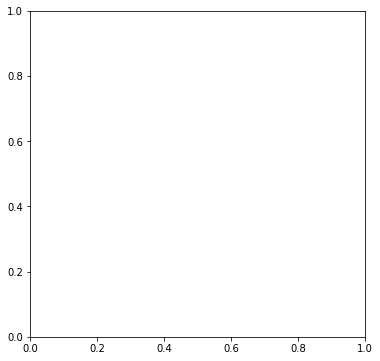

In [10]:
# for roc k-fold
n_splits = 5
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
input_patch_size = (128, 128, 48)
batch_size = 1
val_frac = 0.2
test_frac = 0
length = len(image_files_list)
indices = np.arange(length)
set_determinism(seed=0)
np.random.shuffle(indices)
spatial_dim = 3
pretrained = False
fold_r = {}
cms = []
n_splits = 5
for fold in range(n_splits):
    val_split = int(val_frac * length)
    val_indices = indices[fold*val_split:(fold+1)*val_split]
    val_x = [image_files_list[i] for i in val_indices]
    val_y = [image_class[i] for i in val_indices]

    val_transforms = Compose(
        [
            EnsureChannelFirst(),
            ScaleIntensityRange(
                a_min=-175,
                a_max=250,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
            Resize(input_patch_size),
        ]
    )

   # create a validation data loader
    val_ds = ImageDataset(image_files=val_x, labels=val_y,
                          transform=val_transforms)
    val_loader = DataLoader(
        val_ds, sampler=None, batch_size=batch_size, num_workers=2, pin_memory=pin_memory)

    y_pred_trans = Compose([Activations(softmax=True)])
    y_trans = Compose([AsDiscrete(to_onehot=num_class)])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.densenet121(spatial_dims=spatial_dim, in_channels=1, pretrained=pretrained,
                                            out_channels=num_class, init_features=128, dropout_prob=0).to(device)

    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    val_interval = 1
    auc_metric = ROCAUCMetric()
    auc_metric.average = 'weighted'

    # Test Time Augmentation
    # from monai.data import TestTimeAugmentation

    root_dir = '/home/mohammad/projects/ErrolProjects/spleen/'
    best_metric = -1
    best_acc = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    best_model = f"segmentor_normal_low_high_old_121_608samples_f{fold}.pth"

    model.load_state_dict(torch.load(os.path.join(root_dir, best_model)))
    print(best_model)

    model.eval()
    classcount = np.bincount(val_y).tolist()
    val_weights = 1./torch.tensor(classcount, dtype=torch.float)
    val__sampleweights = val_weights[val_y]

    with torch.no_grad():
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)
        for val_data in val_loader:
            val_images, val_labels = (
                val_data[0].to(device),
                val_data[1].to(device),
            )
            y_pred = torch.cat([y_pred, model(val_images)], dim=0)
            y = torch.cat([y, val_labels.long()], dim=0)

        acc_metric_balanced = balanced_accuracy_score(
            np.array(y.cpu()), np.argmax(np.array(y_pred.cpu()), axis=1))

        y_onehot = [y_trans(i) for i in decollate_batch(y)]
        y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
        # ROC
        y_score = [i.cpu()[0] for i in y_pred_act]

        viz = RocCurveDisplay.from_predictions(
            np.array(y.cpu()),
            y_score,
            pos_label=0, sample_weight=np.array(val__sampleweights.cpu()),
            name=f"ROC fold {fold}",
            alpha=0.6,
            lw=2,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        auc_metric(y_pred_act, y_onehot)
        result = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(result)
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        print(
            f" current AUC: {result:.4f}"
            f" current accuracy: {acc_metric:.4f}"
            f'\n balanced acc = {acc_metric_balanced}'
        )

        cm = confusion_matrix(np.array(y.cpu()), np.argmax(
            np.array(y_pred.cpu()), axis=1))

        # target_names = ['low-grade','high-grade','normal']
        target_names = ['injured', 'normal']
        cms.append(cm)


        y_test = np.array(y.cpu())
        y_score = np.argmax(np.array(y_pred.cpu()), axis=1)

        fold_r[f'{fold}'] = multilabel_confusion_matrix(
            np.array(y.cpu()), np.argmax(np.array(y_pred.cpu()), axis=1))
        # break

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[0]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()